# Aftermath

We have identified some game categories that seem to outperform the others. Overview:

<img src="../0 images/ltd_subgroups_overview.png">

In this workbook we will dive deeper into the validity of those results.

## Data and routines

In [1]:
#setup
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import timeit

In [2]:
#Read in data
df = pd.read_csv('../1 data preparation/20190401-20200312_items_prepped.csv')

In [3]:
def profit_table(df, LTD_start = 0, target_profit = 0.10, underdog_lead_target_profit = 0.10, profit_commission = 0.065,
                 back_F_qcut = [0, .25, .5, .75, 1.], back_noscore_qcut = [0, .20, .75, 1.], Q_beat = None, 
                 underdog_lead_overwrite = True):
    '''
    This function takes in the whole prepped dataframe and some strategy parameters:
    - LTD_start = when to start the strategy. Possible values: 0, 15, 30, 45, 60 or 75. Default 0.
    - target_profit = profit percentage at which bet closure takes place. Value between 0 and 1. Default 0.10.
    - underdog_lead_target_profit = profit percentage at which bet closure takes place, when underdog leads. Value between 0 and 1. Default 0.10.
    - profit_commission = bookie margin taken on net profit. Default 6.5%
    - back_F_qcut = list quantiles to create back_F categories. Default [0, .25, .5, .75, 1.]
    - back_noscore_qcut = list quantiles to create back_noscore categories. Default [0, .20, .75, 1.]
    
    The routine returns the dataframe enriched with data for profit analysis.
    '''
    
    #init
    df_in = df.copy()
    
    #determine Q_beat based on target_profit
    df_in['return_lay'] = 1 / (df_in['lay_X'] - 1)
    df_in['target_profit'] = target_profit
    df_in['stake_close_max'] = df_in['return_lay'] - df_in['target_profit'] #maximum stake for closing the bet, making target_profit
    if (Q_beat is None):
        df_in['Q_beat'] = (df_in['lay_X'] / (1 - (df_in['lay_X'] - 1) * df_in['target_profit'])).round(2)
    else:
        df_in['Q_beat'] = Q_beat
    df_in['profit_Q_beat'] = df_in['Q_beat'] * df_in['stake_close_max'] - 1 - df_in['stake_close_max'] #approx equal to target_profit
    df_in.loc[(df_in['market_name'] != 'Match Odds'),'Q_beat'] = np.nan
    
    #determine the gametags with score = draw at LTD_start
    play_tags = df_in[(df_in['mins15'] == LTD_start) & (df_in['score_diff_label'] == 'F+0')]['gametag'].unique()

    #determine Close and Q_close based on LTD_start
    for (count,gametag) in enumerate(play_tags):
        #sub1: all Match Odds observations for this game, after LTD_start
        ltdstart_row_idx = df_in[(df_in['gametag'] == gametag) & (df_in['mins15'] == LTD_start)].index[0]
        df_sub = df_in[(df_in['gametag'] == gametag) & (df_in['market_name'] == 'Match Odds')].loc[ltdstart_row_idx:,:]
        #set Q-beat equal to the Q_beat at LTD_start for all observations
        df_sub.loc[:,'Q_beat'] = df_sub[(df_sub['mins15'] == LTD_start)]['Q_beat'].iloc[0]
        #overwrite Q_beat for observations where the underdog is leading
        if underdog_lead_overwrite:
            lay_X = df_sub[(df_sub['mins15'] == LTD_start)]['lay_X'].iloc[0]
            Q_beat_und = (lay_X / (1 - (lay_X - 1) * underdog_lead_target_profit)).round(2)
            df_sub.loc[(df_sub['score_diff_label'].str[0:2] == "F-"),'Q_beat'] = Q_beat_und
            df_sub.loc[(df_sub['score_diff_label'].str[0:2] == "F-"),'target_profit'] = underdog_lead_target_profit
        #sub2: all observations with back_X >= Q_beat
        df_sub = df_sub[df_sub['back_X'] >= df_sub['Q_beat']]
        #store Close and Q_close
        if (df_sub.shape[0] == 0):
            df_in.loc[ltdstart_row_idx,'Close'] = False
            df_in.loc[ltdstart_row_idx,'Q_close'] = np.nan
            df_in.loc[ltdstart_row_idx,'gametime_close'] = np.nan
        else:
            df_in.loc[ltdstart_row_idx,'Close'] = True
            df_in.loc[ltdstart_row_idx,'Q_close'] = df_sub['back_X'].iloc[0]
            df_in.loc[ltdstart_row_idx,'gametime_close'] = df_sub['current_gametime_T2'].iloc[0]
            df_in.loc[ltdstart_row_idx,'target_profit'] = df_sub['target_profit'].iloc[0]
            df_in.loc[ltdstart_row_idx,'stake_close_max'] = df_in.loc[ltdstart_row_idx,'return_lay'] - df_in.loc[ltdstart_row_idx,'target_profit']
    
    #outcome
    df_in.loc[(df_in['endscore_label'] == 'F+0') & (df_in['Close'] == False),'outcome'] = 'open_loss'
    df_in.loc[(df_in['endscore_label'] != 'F+0') & (df_in['Close'] == False),'outcome'] = 'open_win'
    df_in.loc[(df_in['Close'] == True),'outcome'] = 'closed_win'
    #closed_win
    df_in.loc[df_in['outcome'] == 'closed_win','stake_close'] = (1+df_in['target_profit']+ df_in['stake_close_max'])/(df_in['Q_close']) #stake needed for closing the bet, making target_profit
    df_in.loc[df_in['outcome'] == 'closed_win','profit_close'] = df_in['target_profit'] + df_in['stake_close_max'] - df_in['stake_close']
    #open_loss
    df_in.loc[df_in['outcome'] == 'open_loss','profit_close'] = -1
    #open_win
    df_in.loc[df_in['outcome'] == 'open_win','profit_close'] = df_in['return_lay']
    
    #net profit
    df_in.loc[df_in['profit_close'] > 0,'net_profit'] = df_in['profit_close'] * (1-profit_commission)
    df_in.loc[df_in['profit_close'] <= 0,'net_profit'] = df_in['profit_close']
    
    #create back_F factors
    df_in.loc[:,'back_F_factor'] = pd.qcut(df_in[(df_in['mins15'] == LTD_start) & (df_in['score_diff_label'] == 'F+0')]['back_F'], 
                                                   q = back_F_qcut)
    
    #back_noscore_calib cut made for each back_F category seperately
    for F_interval in df_in['back_F_factor'].unique().dropna():
        df_in.loc[(df_in['back_F_factor'] == F_interval),
               'back_noscore_calib_factor'] = pd.qcut(df_in[df_in['back_F_factor'] == F_interval]['back_noscore_calib'], 
                                                        q = back_noscore_qcut, labels=np.arange(1,len(back_noscore_qcut),1))
    
    return df_in

In [4]:
def profit_pivot(df, aggreg_function = 'mean'):
    '''
    Function that makes the pivot table of net_profit values for back_F_factor and back_noscore_calib_factor categories
    aggreg_function values are: 'sum', 'mean', 'count'
    '''
    if (aggreg_function == 'count'):
        func = lambda x: len(x)
    else:
        func = aggreg_function
    
    return df.pivot_table(values='net_profit',index='back_F_factor',columns='back_noscore_calib_factor',aggfunc=func,margins=True)

In [5]:
def profit_game_summary(df):
    '''
    Function that creates an overview of the profit calculation per game for a given profit_table
    '''
    return df[~df['net_profit'].isnull()][['gametag','current_score_T2','back_F','back_F_factor','back_noscore_calib','back_noscore_calib_factor',
                                            'back_X','lay_X','Q_beat','return_lay','target_profit','stake_close_max',
                                            'endscore','Close','gametime_close','Q_close','stake_close','profit_close','net_profit']]

<img src="../0 images/ltd_subgroups_overview.png">

## Changing the noscore cutoff

The profits here are **only** for the low scoring likelihood categories. The problem is that we do not have a lot of observations for that category. What would be the effect of cutting the scoring likelihood equally, instead of the default 20-55-25 cutoff?

#### equally divided back_noscore_qcut

In [6]:
#strategy 1 profit tables for equally divided back_noscore_qcut
start = timeit.default_timer()
starts = [0,15,30,45,60,75]
strat_1_tables = [profit_table(df,LTD_start=x,underdog_lead_target_profit = 0.10, 
                               back_noscore_qcut = [0, .33, .67, 1.]) for x in starts]
stop = timeit.default_timer()
print('Runtime: ', stop - start)

C:\Users\nverd\anaconda3\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: divide by zero encountered in double_scalars


Runtime:  223.565043


In [7]:
#strategy 2 profit tables for equally divided back_noscore_qcut
start = timeit.default_timer()
starts = [0,15,30,45,60,75]
strat_2_tables = [profit_table(df,LTD_start=x,underdog_lead_target_profit = 0, 
                               back_noscore_qcut = [0, .33, .67, 1.]) for x in starts]
stop = timeit.default_timer()
print('Runtime: ', stop - start)

Runtime:  232.76689890000003


Now we have equally divided observations:

In [8]:
profit_pivot(strat_1_tables[0], aggreg_function = 'mean') #mins15 == 30

back_noscore_calib_factor,1,2,3,All
back_F_factor,,,,
"(1.1190000000000002, 1.688]",0.015259,0.113726,-0.022337,0.037314
"(1.688, 1.97]",-0.058053,0.024764,0.019301,-0.005337
"(1.97, 2.3]",-0.064918,-0.086380,-0.106488,-0.084939
"(2.3, 3.0]",0.049167,-0.074168,-0.019135,-0.017426
All,-0.016697,-0.005582,-0.032192,-0.017634


For F+ the profit drops from 5.91 (23,7%) to 3.23 (9%):

In [24]:
profit_pivot(strat_2_tables[2], aggreg_function = 'sum')

back_noscore_calib_factor,1,2,3,All
back_F_factor,,,,
"(1.179, 1.86]",-1.979428,0.999963,-3.539189,-4.518655
"(1.86, 2.13]",-5.278891,-1.339544,4.506522,-2.111913
"(2.13, 2.46]",-3.671100,-3.370721,-1.040225,-8.082046
"(2.46, 3.15]",3.232405,-1.337615,-2.010301,-0.115511
All,-7.697015,-5.047917,-2.083193,-14.828125


Note: this is mainly because 4 out of the 11 new observations are no scoring games. Out of 25 games (20% cut) there were actually 0 no scoring games, for the category with the lowest scoring likelihood. This is not representative. We will analyze this further below. For here we can conclude that the decrease in profit is not so much related to the change in cut but to a more representative sample with noscore games.

In [47]:
strat_2_game_summaries = [profit_game_summary(x) for x in strat_2_tables]

In [25]:
st = strat_2_game_summaries[2]
fav_cat = st['back_F_factor'].unique().dropna().sort_values()[3]
st_sub = st[(st['back_F_factor'] == fav_cat) & (st['back_noscore_calib_factor'] == 1)]
st_sub.to_excel('./output/strat_2_mins30_low_fav_low_sl_eq_div_game_summaries.xlsx',index=False)

For F++ the profit drops from 2.14 (10,7%) to 1.32 (4,9%):

In [45]:
profit_pivot(strat_2_tables[2], aggreg_function = 'count')

back_noscore_calib_factor,1,2,3,All
back_F_factor,,,,
"(1.179, 1.86]",40.0,35.0,36.0,111.0
"(1.86, 2.13]",42.0,35.0,32.0,109.0
"(2.13, 2.46]",43.0,35.0,34.0,112.0
"(2.46, 3.15]",36.0,42.0,30.0,108.0
All,161.0,147.0,132.0,440.0


Also here: from the 12 extras there are 3 noscore games (25%). This is more than the 4 out of 20 (20%). This explains the change in net_profit, not the change in cut. Further analysis below.

In [52]:
st = strat_2_game_summaries[2]
fav_cat = st['back_F_factor'].unique().dropna().sort_values()[3]
st_sub = st[(st['back_F_factor'] == fav_cat) & (st['back_noscore_calib_factor'] == 1)]
st_sub.to_excel('./output/strat_2_mins30_low_fav_low_sl_three_cat_eq_div_game_summaries.xlsx',index=False)

The total picture for cutting the scoring likelihood equally becomes:

In [28]:
strat_2_mean_pivots = [profit_pivot(x, aggreg_function = 'mean') for x in strat_2_tables]

In [29]:
results_all_flat = pd.DataFrame(columns=['fav_cat','scoring_likelihood','net_profit','LTD_start','strategy'])

for (nr,i) in enumerate([strat_2_mean_pivots]):
    for j in np.arange(0,6,1):
        x = pd.DataFrame(i[j].drop('All').drop('All',axis=1))
        x.index = ['F++++','F+++','F++','F+']
        x.reset_index(drop=False,inplace=True)
        x = x.melt(id_vars=["index"], var_name="scoring_likelihood", value_name="net_profit")
        x.columns = ['fav_cat','scoring_likelihood','net_profit']
        x['LTD_start'] = starts[j]
        x['strategy'] = nr+1
        results_all_flat = results_all_flat.append(x,ignore_index=True)

<Figure size 1440x720 with 0 Axes>

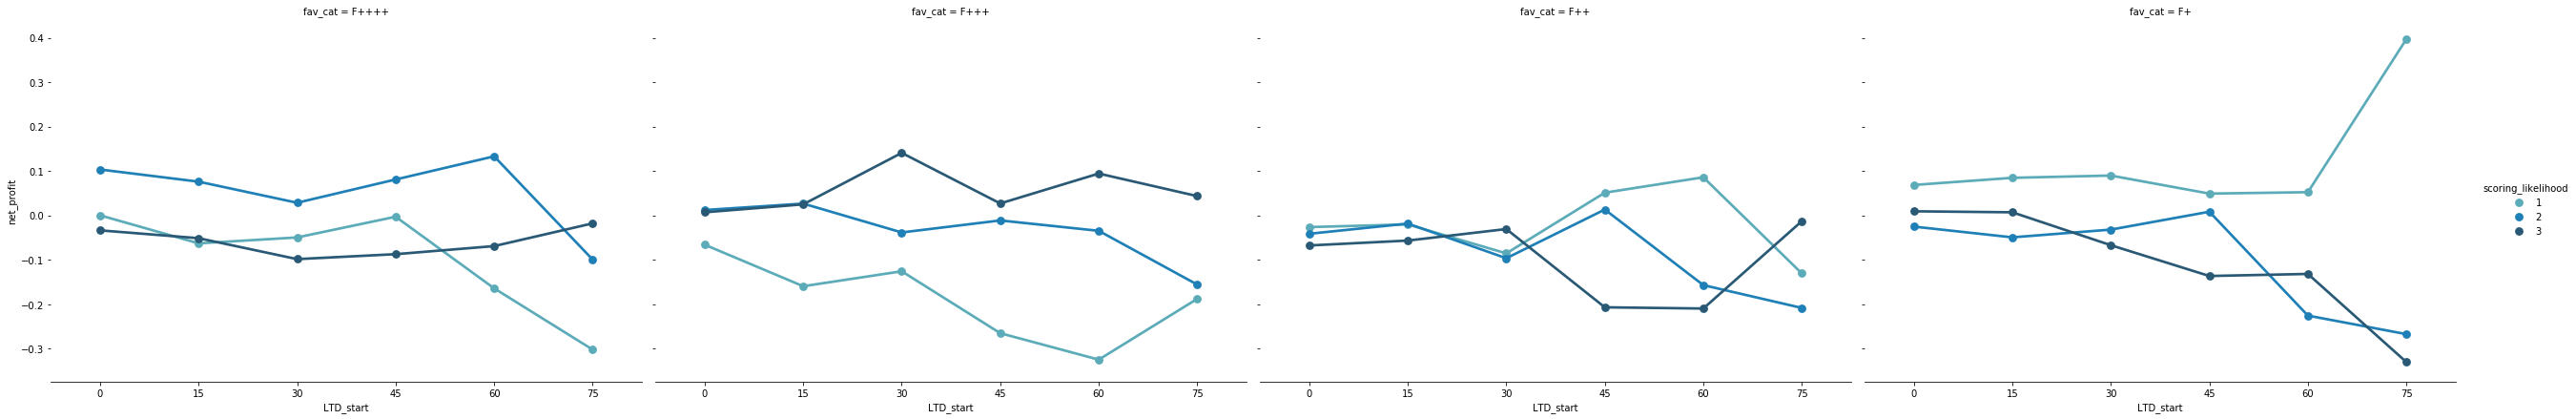

In [30]:
plt.figure(figsize = (20,10))
g = sns.catplot(x="LTD_start", y="net_profit", hue="scoring_likelihood", col="fav_cat",
                capsize=.2, palette="YlGnBu_d", height=6, aspect=1.5,
                kind="point", data=results_all_flat)
g.despine(left=True)

In [31]:
g.savefig("./output/appendix_B")

It can be seen that still:
- the low scoring likelihood category outperforms the others for F++ and F+ (T=45 and T=30)
- the medium scoring likelihood category outperforms the others for F++++ (T=0)

So the picture doesn't really change with this, which is good.

#### 2 instead of 3 back_noscore_factors

To get even more observations (and significance) we could also cut the scoring likelihood into 2 categories instead of 3. What would be the impact of this?

In [9]:
#strategy 1 profit tables for 2 equally divided back_noscore categories
start = timeit.default_timer()
starts = [0,15,30,45,60,75]
strat_1_tables = [profit_table(df,LTD_start=x,underdog_lead_target_profit = 0.10, 
                               back_noscore_qcut = [0, .50, 1.]) for x in starts]
stop = timeit.default_timer()
print('Runtime: ', stop - start)

C:\Users\nverd\anaconda3\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: divide by zero encountered in double_scalars


Runtime:  97.370341


In [ ]:
#strategy 2 profit tables for 2 equally divided back_noscore categories
start = timeit.default_timer()
starts = [0,15,30,45,60,75]
strat_2_tables = [profit_table(df,LTD_start=x,underdog_lead_target_profit = 0, 
                               back_noscore_qcut = [0, .50, 1.]) for x in starts]
stop = timeit.default_timer()
print('Runtime: ', stop - start)

In [33]:
strat_2_mean_pivots = [profit_pivot(x, aggreg_function = 'mean') for x in strat_2_tables]
strat_2_game_summaries = [profit_game_summary(x) for x in strat_2_tables]

In [34]:
st = strat_2_game_summaries[2]
fav_cat = st['back_F_factor'].unique().dropna().sort_values()[3]
st_sub = st[(st['back_F_factor'] == fav_cat) & (st['back_noscore_calib_factor'] == 1)]
st_sub.to_excel('./output/strat_2_mins30_low_fav_low_sl_two_cat_eq_div_game_summaries.xlsx',index=False)

st = strat_2_game_summaries[3]
fav_cat = st['back_F_factor'].unique().dropna().sort_values()[2]
st_sub = st[(st['back_F_factor'] == fav_cat) & (st['back_noscore_calib_factor'] == 1)]
st_sub.to_excel('./output/strat_2_mins45_mediumlow_fav_low_sl_two_cat_eq_div_game_summaries.xlsx',index=False)

In [35]:
results_all_flat = pd.DataFrame(columns=['fav_cat','scoring_likelihood','net_profit','LTD_start','strategy'])

for (nr,i) in enumerate([strat_2_mean_pivots]):
    for j in np.arange(0,6,1):
        x = pd.DataFrame(i[j].drop('All').drop('All',axis=1))
        x.index = ['F++++','F+++','F++','F+']
        x.reset_index(drop=False,inplace=True)
        x = x.melt(id_vars=["index"], var_name="scoring_likelihood", value_name="net_profit")
        x.columns = ['fav_cat','scoring_likelihood','net_profit']
        x['LTD_start'] = starts[j]
        x['strategy'] = nr+1
        results_all_flat = results_all_flat.append(x,ignore_index=True)

<Figure size 1440x720 with 0 Axes>

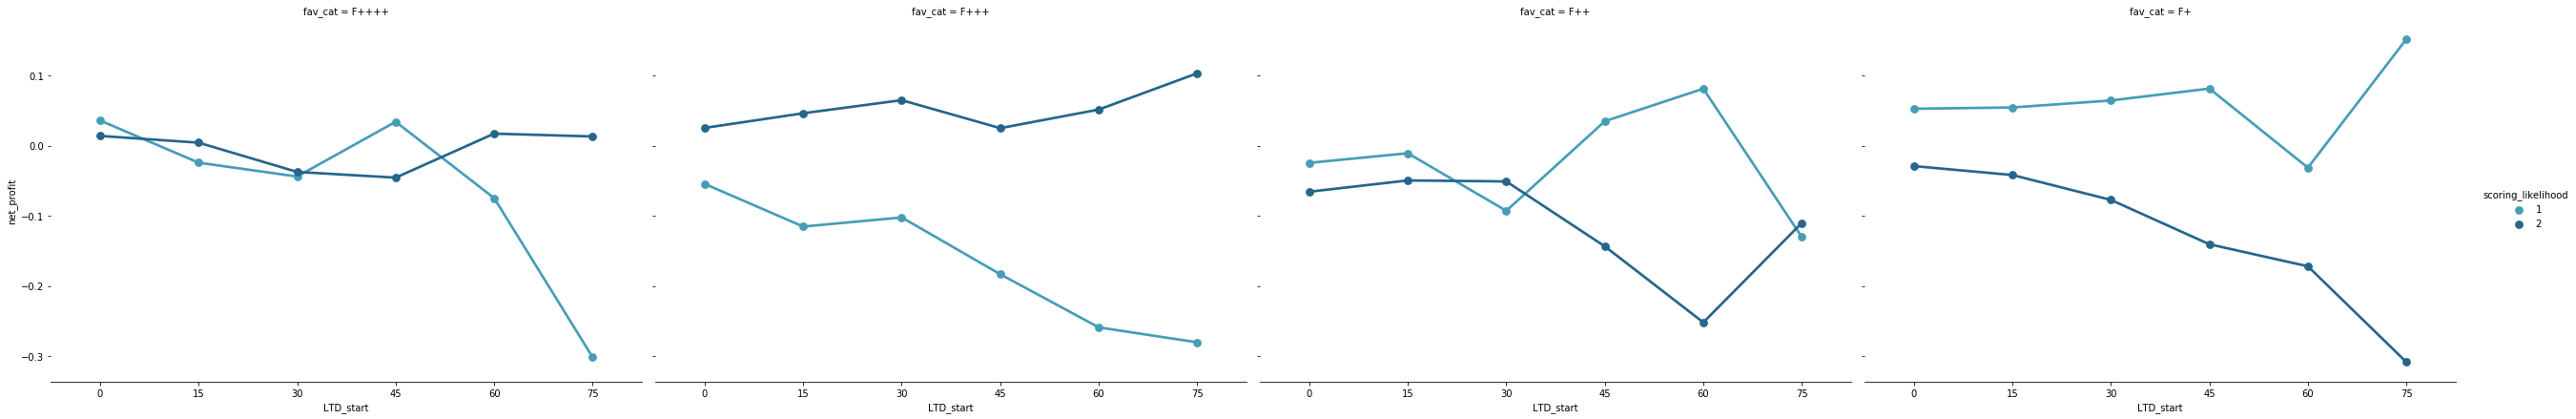

In [36]:
plt.figure(figsize = (20,10))
g = sns.catplot(x="LTD_start", y="net_profit", hue="scoring_likelihood", col="fav_cat",
                capsize=.2, palette="YlGnBu_d", height=6, aspect=1.5,
                kind="point", data=results_all_flat)
g.despine(left=True)

In [37]:
g.savefig("./output/appendix_B")

If we do this:
- the trend stays the same for F+ and F++: a good bet to select the low scoring likelihood respectively at T=30 and T=45
- the trend changes for F++++ and F+++: logical because there it was concluded to actually take the **middle** category, which is now gone

And we do get more game counts for our F+ and F++ groups, so more validity:

In [11]:
profit_pivot(strat_1_tables[0], aggreg_function = 'count')

back_noscore_calib_factor,1,2,All
back_F_factor,,,
"(1.1190000000000002, 1.688]",106.0,104.0,210.0
"(1.688, 1.97]",111.0,102.0,213.0
"(1.97, 2.3]",110.0,101.0,211.0
"(2.3, 3.0]",113.0,93.0,206.0
All,440.0,400.0,840.0


In [117]:
profit_pivot(strat_2_tables[3], aggreg_function = 'count') #48 for F++ at T=45

back_noscore_calib_factor,1,2,All
back_F_factor,,,
"(1.2890000000000001, 2.06]",49.0,43.0,92.0
"(2.06, 2.42]",44.0,40.0,84.0
"(2.42, 2.78]",48.0,41.0,89.0
"(2.78, 3.6]",41.0,39.0,80.0
All,182.0,163.0,345.0


In [19]:
print('F+ low SL at T=30')
print('Sum profit: ', profit_pivot(strat_2_tables[2], aggreg_function = 'sum').iloc[3,0])
print('Game count: ', profit_pivot(strat_2_tables[2], aggreg_function = 'count').iloc[3,0])
print('Mean profit: ', profit_pivot(strat_2_tables[2], aggreg_function = 'mean').iloc[3,0])
print('F++ low SL at T=45')
print('Sum profit: ', profit_pivot(strat_2_tables[3], aggreg_function = 'sum').iloc[2,0])
print('Game count: ', profit_pivot(strat_2_tables[3], aggreg_function = 'count').iloc[2,0])
print('Mean profit: ', profit_pivot(strat_2_tables[3], aggreg_function = 'mean').iloc[2,0])

F+ low SL at T=30
Sum profit:  3.743987053611609
Game count:  58.0
Mean profit:  0.06455150092433809
F++ low SL at T=45
Sum profit:  1.6783489304456345
Game count:  48.0
Mean profit:  0.03496560271761739


## F+ and F++: conclusion

~~From all this it can be confirmed that there is some 'signal' in selecting the games with **low scoring likelihood** from the F+ and F++ category at starting times respectively T=30 and T=45.~~

### Sidestep F+ and F++: difference between home and away favourite?

We got 5.75 and 3.83 net profit from our strategy 2 used on the F+ and F++ game categories. Is there a difference in contribution from home and away favourites?

In [20]:
data = strat_2_tables[2]
homefav_gametags = data.loc[(data['mins15'] == 30) & (data['F_home'] == True)]['gametag'].unique()
awayfav_gametags = data.loc[(data['mins15'] == 30) & (data['F_home'] == False)]['gametag'].unique()

In [21]:
#strategy 2 profit tables for 2 equally divided back_noscore categories, T=30
strat_2_table_home_30 = data[data['gametag'].isin(homefav_gametags)]
strat_2_table_away_30 = data[data['gametag'].isin(awayfav_gametags)]

In [22]:
print('F+ low SL at T=30')
print('Home')
print('Sum profit: ', profit_pivot(strat_2_table_home_30, aggreg_function = 'sum').iloc[3,0])
print('Game count: ', profit_pivot(strat_2_table_home_30, aggreg_function = 'count').iloc[3,0])
print('Mean profit: ', profit_pivot(strat_2_table_home_30, aggreg_function = 'mean').iloc[3,0])
print('Away')
print('Sum profit: ', profit_pivot(strat_2_table_away_30, aggreg_function = 'sum').iloc[3,0])
print('Game count: ', profit_pivot(strat_2_table_away_30, aggreg_function = 'count').iloc[3,0])
print('Mean profit: ', profit_pivot(strat_2_table_away_30, aggreg_function = 'mean').iloc[3,0])

F+ low SL at T=30
Home
Sum profit:  2.052996483957133
Game count:  32.0
Mean profit:  0.0641561401236604
Away
Sum profit:  1.6909905696544776
Game count:  26.0
Mean profit:  0.06503809883286452


For the F+ category the contribution is very equal.

In [23]:
data = strat_2_tables[3]
homefav_gametags = data.loc[(data['mins15'] == 45) & (data['F_home'] == True)]['gametag'].unique()
awayfav_gametags = data.loc[(data['mins15'] == 45) & (data['F_home'] == False)]['gametag'].unique()

In [24]:
#strategy 2 profit tables for 2 equally divided back_noscore categories, T=30
strat_2_table_home_45 = data[data['gametag'].isin(homefav_gametags)]
strat_2_table_away_45 = data[data['gametag'].isin(awayfav_gametags)]

In [25]:
print('F++ low SL at T=45')
print('Home')
print('Sum profit: ', profit_pivot(strat_2_table_home_45, aggreg_function = 'sum').iloc[2,0])
print('Game count: ', profit_pivot(strat_2_table_home_45, aggreg_function = 'count').iloc[2,0])
print('Mean profit: ', profit_pivot(strat_2_table_home_45, aggreg_function = 'mean').iloc[2,0])
print('Away')
print('Sum profit: ', profit_pivot(strat_2_table_away_45, aggreg_function = 'sum').iloc[2,0])
print('Game count: ', profit_pivot(strat_2_table_away_45, aggreg_function = 'count').iloc[2,0])
print('Mean profit: ', profit_pivot(strat_2_table_away_45, aggreg_function = 'mean').iloc[2,0])

F++ low SL at T=45
Home
Sum profit:  -0.6611275766625009
Game count:  39.0
Mean profit:  -0.01695198914519233
Away
Sum profit:  2.3394765071081354
Game count:  9.0
Mean profit:  0.25994183412312616


For the F++ category the profit seems to come mostly from the 9 away games.

## Strategy 3: what if we did not close?

Was our strategy more profitable than simply betting against the draw, without closing out? Let's investigate this.

In [26]:
#strategy 3: never closing
# (for this we have slightly changed the routine: added Q_beat and underdog_lead_overwrite as a parameter)
start = timeit.default_timer()
starts = [0,15,30,45,60,75]
strat_3_tables = [profit_table(df,LTD_start=x,Q_beat = 200, underdog_lead_overwrite = False) for x in starts]
stop = timeit.default_timer()
print('Runtime: ', stop - start)

Runtime:  84.53290119999997


In [27]:
#611 open wins and 229 open losses
strat_3_tables[0]['outcome'].value_counts()

open_win     611
open_loss    229
Name: outcome, dtype: int64

In [28]:
#pivots
strat_3_mean_pivots = [profit_pivot(x, aggreg_function = 'mean') for x in strat_3_tables]
strat_3_count_pivots = [profit_pivot(x, aggreg_function = 'count') for x in strat_3_tables]
strat_3_sum_pivots = [profit_pivot(x, aggreg_function = 'sum') for x in strat_3_tables]

In [128]:
#profit per game summaries
strat_3_game_summaries = [profit_game_summary(x) for x in strat_3_tables]

st = strat_3_game_summaries[0]
fav_cat = st['back_F_factor'].unique().dropna().sort_values()[0]
st_sub = st[(st['back_F_factor'] == fav_cat) & (st['back_noscore_calib_factor'] == 2)]
st_sub.to_excel('./output/strat_3_mins0_high_fav_medium_sl_game_summaries.xlsx',index=False)

st = strat_3_game_summaries[0]
fav_cat = st['back_F_factor'].unique().dropna().sort_values()[1]
st_sub = st[(st['back_F_factor'] == fav_cat) & (st['back_noscore_calib_factor'] == 2)]
st_sub.to_excel('./output/strat_3_mins0_mediumhigh_fav_medium_sl_game_summaries.xlsx',index=False)

st = strat_3_game_summaries[2]
fav_cat = st['back_F_factor'].unique().dropna().sort_values()[1]
st_sub = st[(st['back_F_factor'] == fav_cat) & (st['back_noscore_calib_factor'] == 3)]
st_sub.to_excel('./output/strat_3_mins30_mediumhigh_fav_high_sl_game_summaries.xlsx',index=False)

st = strat_3_game_summaries[3]
fav_cat = st['back_F_factor'].unique().dropna().sort_values()[2]
st_sub = st[(st['back_F_factor'] == fav_cat) & (st['back_noscore_calib_factor'] == 1)]
st_sub.to_excel('./output/strat_3_mins45_mediumlow_fav_low_sl_game_summaries.xlsx',index=False)

st = strat_3_game_summaries[2]
fav_cat = st['back_F_factor'].unique().dropna().sort_values()[3]
st_sub = st[(st['back_F_factor'] == fav_cat) & (st['back_noscore_calib_factor'] == 1)]
st_sub.to_excel('./output/strat_3_mins30_low_fav_low_sl_game_summaries.xlsx',index=False)

Overall (if played on all games), we make more loss than with strategy 1 (-14) or 2 (-4):

In [129]:
strat_3_sum_pivots[0]

back_noscore_calib_factor,1,2,3,All
back_F_factor,,,,
"(1.1190000000000002, 1.688]",-0.405686,10.243203,0.337395,10.174912
"(1.688, 1.97]",-4.127556,-1.946066,1.003944,-5.069678
"(1.97, 2.3]",-1.799391,-16.933198,-6.212906,-24.945495
"(2.3, 3.0]",-1.049328,-12.312208,-2.622897,-15.984432
All,-7.381961,-20.948269,-7.494463,-35.824693


What about our chosen categories?

<img src="../0 images/ltd_subgroups_overview.png">

In [29]:
#F++++ T=0
st = strat_3_tables[0]
fav_cat = st['back_F_factor'].unique().dropna().sort_values()[0]
print('Sum: ',st[(st['back_F_factor'] == fav_cat) & (st['back_noscore_calib_factor'] == 2)]['net_profit'].sum())

Sum:  10.243202913931789


In [30]:
#F+++ T=0
st = strat_3_tables[0]
fav_cat = st['back_F_factor'].unique().dropna().sort_values()[1]
print('Sum: ',st[(st['back_F_factor'] == fav_cat) & (st['back_noscore_calib_factor'] == 2)]['net_profit'].sum())

Sum:  -1.9460658136456181


In [31]:
#F+++ T=30
st = strat_3_tables[2]
fav_cat = st['back_F_factor'].unique().dropna().sort_values()[1]
print('Sum: ',st[(st['back_F_factor'] == fav_cat) & (st['back_noscore_calib_factor'] == 3)]['net_profit'].sum())

Sum:  5.903744173170697


In [32]:
#F++ T=45
st = strat_3_tables[3]
fav_cat = st['back_F_factor'].unique().dropna().sort_values()[2]
print('Sum: ',st[(st['back_F_factor'] == fav_cat) & (st['back_noscore_calib_factor'] == 1)]['net_profit'].sum())

Sum:  2.2305490752032053


In [33]:
#F+ T=30
st = strat_3_tables[2]
fav_cat = st['back_F_factor'].unique().dropna().sort_values()[3]
print('Sum: ',st[(st['back_F_factor'] == fav_cat) & (st['back_noscore_calib_factor'] == 1)]['net_profit'].sum())

Sum:  3.0879437783662125


### Conclusion

Our strategy performed +/- similar to strategy 3 (lay and go) for category 1 (F++++ T=0) and category 4 (F++ T=45). 

Our strategy performed better for category 2 (F+++ T=0) and category 5 (F+ T=30). 

Our strategy performed worse for category 3 (F+++ T=30). This means that the 'signal' is more in laying the draw on those specific games than on applying our strategy on those specific games. We will therefore drop category 3.

## Delta analysis for all categories

Actually this is another way of assessing the performance of our strategy. What is the delta net profit with the 'lay and go' strategy? Let's do this analysis for all game categories.

In [135]:
#list of strategy 1 profit tables
start = timeit.default_timer()
starts = [0,15,30,45,60,75]
strat_1_tables = [profit_table(df,LTD_start=x,underdog_lead_target_profit = 0.10) for x in starts]
stop = timeit.default_timer()
print('Runtime: ', stop - start)

C:\Users\nverd\anaconda3\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: divide by zero encountered in double_scalars


Runtime:  94.11760289999984


In [136]:
#list of strategy 2 profit tables
start = timeit.default_timer()
starts = [0,15,30,45,60,75]
strat_2_tables = [profit_table(df,LTD_start=x,underdog_lead_target_profit = 0) for x in starts]
stop = timeit.default_timer()
print('Runtime: ', stop - start)

Runtime:  96.10561710000002


In [137]:
strat_1_sum_pivots = [profit_pivot(x, aggreg_function = 'sum') for x in strat_1_tables]
strat_2_sum_pivots = [profit_pivot(x, aggreg_function = 'sum') for x in strat_2_tables]

In [138]:
#strategy 1 and 2 all results flat
strat_1_mean_pivots = [profit_pivot(x, aggreg_function = 'mean') for x in strat_1_tables]
strat_2_mean_pivots = [profit_pivot(x, aggreg_function = 'mean') for x in strat_2_tables]

results_1_2_flat = pd.DataFrame(columns=['fav_cat','scoring_likelihood','net_profit','LTD_start','strategy'])

for (nr,i) in enumerate([strat_1_mean_pivots, strat_2_mean_pivots]):
    for j in np.arange(0,6,1):
        x = pd.DataFrame(i[j].drop('All').drop('All',axis=1))
        x.index = ['F++++','F+++','F++','F+']
        x.reset_index(drop=False,inplace=True)
        x = x.melt(id_vars=["index"], var_name="scoring_likelihood", value_name="net_profit")
        x.columns = ['fav_cat','scoring_likelihood','net_profit']
        x['LTD_start'] = starts[j]
        x['strategy'] = nr+1
        results_1_2_flat = results_1_2_flat.append(x,ignore_index=True)

In [140]:
#strategy 3 all results flat
results_3_flat = pd.DataFrame(columns=['fav_cat','scoring_likelihood','net_profit','LTD_start'])

for j in np.arange(0,6,1):
    x = pd.DataFrame(strat_3_mean_pivots[j].drop('All').drop('All',axis=1))
    x.index = ['F++++','F+++','F++','F+']
    x.reset_index(drop=False,inplace=True)
    x = x.melt(id_vars=["index"], var_name="scoring_likelihood", value_name="net_profit")
    x.columns = ['fav_cat','scoring_likelihood','net_profit']
    x['LTD_start'] = starts[j]
    results_3_flat = results_3_flat.append(x,ignore_index=True)

In [145]:
#flat results in 1 table
results_1_2_3_flat = results_1_2_flat.merge(results_3_flat,how='inner',on=['fav_cat','scoring_likelihood','LTD_start'])
results_1_2_3_flat.columns = np.append(results_1_2_flat.columns.values,['net_profit_3'])
results_1_2_3_flat['net_profit_delta'] = results_1_2_3_flat['net_profit'] - results_1_2_3_flat['net_profit_3']
results_1_2_3_flat.head()

,fav_cat,scoring_likelihood,net_profit,LTD_start,strategy,net_profit_3,net_profit_delta
0,F++++,1,-0.032504,0,1,-0.009220,-0.023284
1,F++++,1,-0.044024,0,2,-0.009220,-0.034804
2,F+++,1,-0.104510,0,1,-0.082551,-0.021959
3,F+++,1,-0.104583,0,2,-0.082551,-0.022032
4,F++,1,-0.037321,0,1,-0.040895,0.003575


So we have seen that our strategy 1 and 2 outperform strategy 3 overall (played on all games), but how is that per category?

<Figure size 720x1440 with 0 Axes>

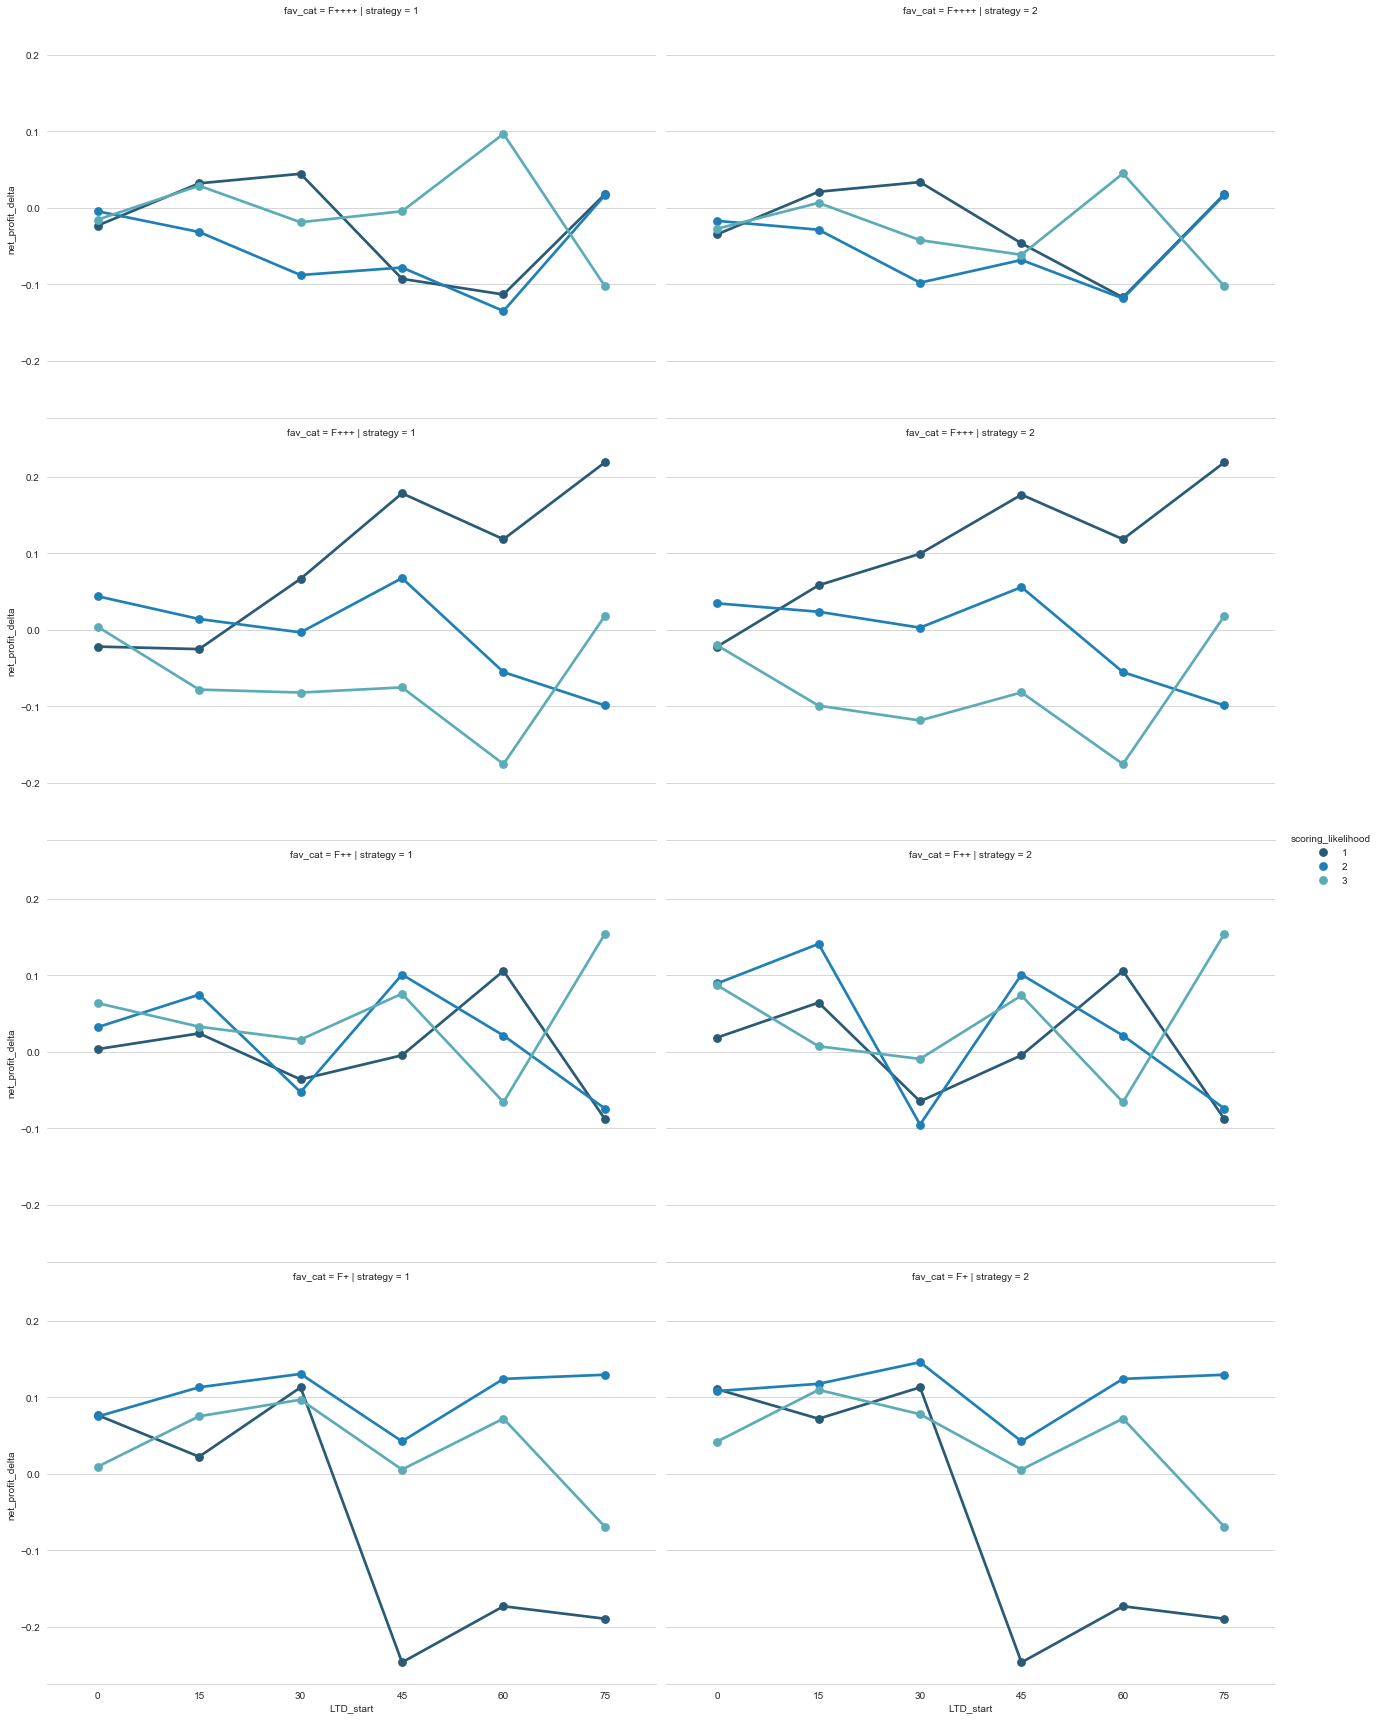

In [146]:
sns.set_style("whitegrid")
plt.figure(figsize = (10,20))
g = sns.catplot(x="LTD_start", y="net_profit_delta", hue="scoring_likelihood", row="fav_cat", col="strategy",
                capsize=.2, palette="YlGnBu_d", height=6, aspect=1.5,
                kind="point", data=results_1_2_3_flat)
g.despine(left=True)

## Conclusion from delta with 'lay and go' analysis

First, for the chosen game categories, the conclusions remain the same as concluded above:
- for F++++, T=0 our strategy does not seem to be better or worse than the lay and go strategy
- for F+++, T=0 our strategy seems to be slightly better
- for F+++, T=30, our strategy performs significally worse
- for F++, T=45 our strategy performs the same (but much better at T=60!)
- for F+, T=30 our strategy performs significally better (but much worse at T=45 or later!)

If we consider the 'lay and go' strategy as the baseline (i.e. the lay quotes respresent the 'actual' outcome probabilities), we should assess our strategies against this. However, also here when comparing, we should consider that some categories, especially the low+high socring likelihood and higher LTD starts, have very few observations. So a couple of games with specific events can already distort the conclusions.

Considering all this, we decide to:
- F++++, T=0 -> drop
- F+++, T=0 -> keep
- F+++, T=30 -> drop
- F++, T=45 -> keep:
    - we will not drop: our strategy outperforms lay and go when considering all SL observations
    - we will not change to T=60: our strategy outperforms lay and go more at T=45 when considering all SL observations
- F+, T=30 -> keep

So we drop categories 1 and 3 from our match selections based on this analysis.

Second, are there new categories to be considered based on this analysis?
- our strategy seems to significantly outperform lay and go for low scoring likelihood F+++ at T=45 and later. However even then the results with our strategy are still -20% -> not select
- our strategy 2 seems to significantly outperform lay and go for F++ medium and high scoring likelihood at T=0 (+9%). However even with this the net_profits are around -5% -> not select
- our strategy 2 seems to significantly outperform lay and go for F+ medium and low scoring likelihood at T=0 (+11%). Low is already selected. For medium the results are 0% so we will still not select. 

Based on the last observation we could consider to broaden our low scoring likelihood bucket. But above we have seen that:
- changing to 3 equal buckets: profit changes from 5.91 in 25 games to 3.23 in 36 games
- changing to 2 equal buckets: profit changes from 5.91 in 25 games to 3.74 in 58 games

So we will keep as is.